## Import

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import cv2 as cv

from scipy.ndimage import convolve, affine_transform
from skimage.feature import peak_local_max

import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
sys.path.insert(1, '..')
from functions import *
from local_features import *

PATH = 'data/'

In [19]:
path_train_image = PATH + '/3labels/training_image.png'
path_train_label = PATH + '/3labels/training_labels.png'
path_test_image  = PATH + '/3labels/testing_image.png'
path_test_label  = PATH + '/3labels/testing_labels.png'

train_image = skimage.io.imread(path_train_image).astype(float)/255
train_label = skimage.io.imread(path_train_label).astype(float)/255
test_image = skimage.io.imread(path_test_image).astype(float)/255
test_label = skimage.io.imread(path_test_label).astype(float)/255
num_train_labels = len(set(train_label.flatten()))

scales = [1, 2 , 3]

## 4.2.1 Compute features

To ensure that you have time to complete the exercise, we have prepared the function for computing the Gaussian feature image. It is available as the functions get_gauss_feat_multi function in the ``local_features.py`` file. Its functionality is described in the help text of the functions. You should start by computing these features and visually inspect what they look like. You will start working with the training image.

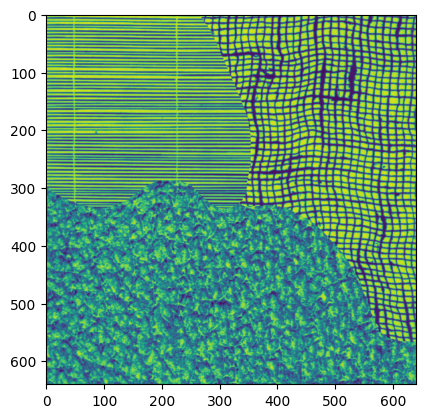

In [20]:
#image = image[200:400, 200:400] # smaller image such that we can see 
fig, ax = plt.subplots()
ax.imshow(train_image)

In [21]:
def compute_gaussian_features(train_image, sigmas):
    return get_gauss_feat_multi(train_image, sigmas).reshape((train_image.shape[0],train_image.shape[1], -1))

In [22]:
train_features = compute_gaussian_features(train_image, scales)
print(f'The shape of the feature matrix is {train_features.shape}')

The shape of the feature matrix is (640, 640, 45)


## 4.2.2 Prepare labels for clustering

The label image stores the label information as unique intensity values. Since we want to use the labels for computing label probabilities, we must create a representation of the label image that can be used for this. In the exercise, you will work with two and three labels, but let the number of unique labels be $n_l$. Hereby, the values in the label image are $[0, ..., n_l − 1]$. Then we construct a new image that we call $\mathcal{L} \in \mathbb{R}^{r \times c \times n_l}$ ,
that stores label probabilities. This means that each pixel of L has the value one in the dimension of the label and zero in the rest. You should transform the training label image to a label probability image.

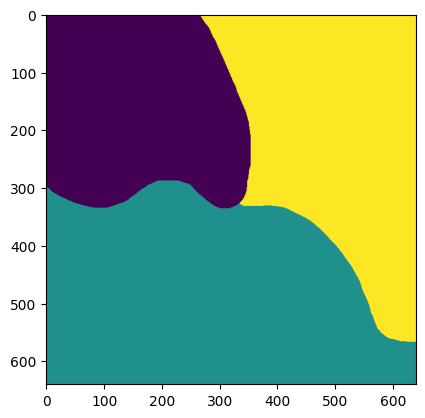

In [23]:
plt.figure()
plt.imshow(train_label)

In [24]:
def split_labels_into_probabilities(train_label):
    """
    Split the label image into separate binary images for each label (probabilities)

    Parameters:
        train_label (numpy.ndarray): The label image.
        train_image (numpy.ndarray): The training image.

    Returns:
        numpy.ndarray: The split label image with shape (H, W, n_labels).
    """
    
    label_set = set(train_label.flatten())
    label_split = np.zeros((train_label.shape[0], train_label.shape[1], len(label_set)))
    for i, l in enumerate(label_set):
        label_split[:, :, i] = train_label == l
    
    return label_split

label_split = split_labels_into_probabilities(train_label)
print('Labels:', len(set(train_label.flatten())))
print('The shape of the label split:', label_split.shape)

Labels: 3
The shape of the label split: (640, 640, 3)


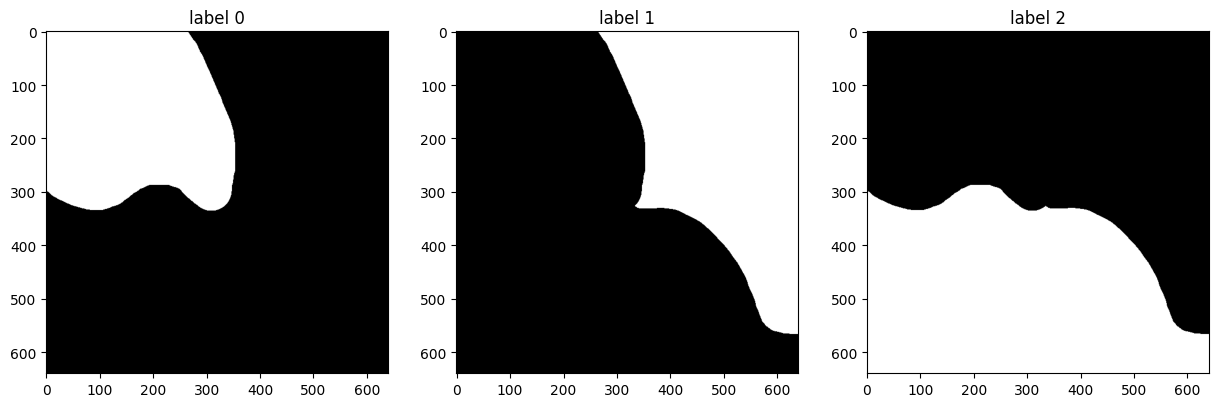

In [25]:
fig, ax = plt.subplots(1, label_split.shape[-1], figsize=(15, 5))
for i in range(label_split.shape[-1]):
    ax[i].imshow(label_split[:, :, i], cmap='gray')
    ax[i].set_title(f'label {i}')
plt.show()

## 4.2.3 Build dictionary

You should use k-means clustering for building the dictionary. Using all feature vectors for building the dictionary is very time-consuming, and it is sufficient to select a random subset of features. It is important that the subset is chosen randomly to be representative for the training image. You should both sample features and the image
labels, i.e. labels should be sampled from the same pixel positions as the features. The labels are used for computing the label probabilities of the clusters according to Eq. 4.2 and 4.3.

1. **Select a random subset of feature vectors**

    with corresponding labels (you can use random permutation). If you choose e.g. 5000-10000 vectors, it should be sufficient for clustering.

2. **Use k-means to cluster the feature vectors into several clusters**

    You can use KMeans from Scikit Learn and choose e.g. 100-1000 clusters.

3. **Make an $n_l$ × $n_c$ array to store label probabilities**

    where $n_c$ is the number of cluster centers. Compute the probability of a cluster belonging to each of the labels using Eq. 4.2 and 4.3, and store the probabilities in the array.

$$
p_C(\lambda) = \frac{1}{|C|} \sum_{f \in C} \delta (\ell(f) - \lambda),
\tag{4.2}
$$

$$
\delta(x) = 
\begin{cases} 
1 & \text{if } x = 0 \\ 
0 & \text{otherwise} 
\end{cases}.
\tag{4.3}
$$

In [26]:
def permutation(feature, label, n_samples):
    """
    Permute and select a subset of features and labels.

    Parameters:
        feature (numpy.ndarray): The feature array of shape (H, W, D1).
        label (numpy.ndarray): The label array of shape (H, W, D2).
        n_samples (int): The number of samples to select.

    Returns:
        tuple: A tuple containing the selected features and labels.
               - feature_selected (numpy.ndarray): The selected feature array of shape (n_samples, D1).
               - labels_selected (numpy.ndarray): The selected label array of shape (n_samples, D2).
    """
    # Flatten first two dimensions
    feature_flat = feature.reshape(-1, feature.shape[-1])  # Shape (H*W, D1)
    label_flat = label.reshape(-1, label.shape[-1])  # Shape (H*W, D2)
    # Generate permutation
    perm = np.random.permutation(feature_flat.shape[0])

    # Select first n_samples elements from the permutation
    selected_indices = perm[:n_samples]

    # Apply the selection
    feature_selected = feature_flat[selected_indices]  
    labels_selected = label_flat[selected_indices]  

    return feature_selected, labels_selected


In [27]:
feature_selected, labels_selected = permutation(train_features, label_split, 30000)

print('The shape of the selected features:', feature_selected.shape)
print('The shape of the selected labels:', labels_selected.shape)

The shape of the selected features: (30000, 45)
The shape of the selected labels: (30000, 3)


In [28]:
num_clusters = 2000

kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size = 2*num_clusters, n_init='auto', random_state=42)
cluster_assignments = kmeans.fit_predict(feature_selected)

In [29]:
label_probabilities = np.zeros((num_train_labels, num_clusters))  # Shape (n_l, n_c)

label_probabilities = np.zeros((num_train_labels, num_clusters))  # Shape (n_l, n_c)

for cluster in range(num_clusters):
    # Get indices of all feature vectors assigned to this cluster
    cluster_indices = np.where(cluster_assignments == cluster)[0]

    # Get the corresponding multi-hot label vectors
    cluster_labels = labels_selected[cluster_indices]  # Shape: (N_c, num_train_labels)

    # Sum over each label dimension
    if len(cluster_indices) > 0:
        label_counts = np.sum(cluster_labels, axis=0)  # Shape: (num_train_labels,)
        label_probabilities[:, cluster] = label_counts / len(cluster_indices)
    
    # print(f'Cluster {cluster}: {len(cluster_indices)} samples, label counts: {label_counts}, probabilities: {label_probabilities[:, cluster]}')   
# === Output ===
print("Computed label probabilities shape:", label_probabilities.shape, "")

Computed label probabilities shape: (3, 2000) 


## 4.2.4 Assign dictionary to test image

You now have a dictionary that can be used for segmentation in the form of cluster centers with label probabilities. You can now assign each pixel in your test image to the nearest dictionary element and use the label probabilities of these dictionary elements for your segmentation. We will do this, but first getting the index of the dictionary element for each pixel in the test image.

**1. Compute a feature image from the test image**

**2. Find the nearest neighbors to all feature vectors**
    
    You can use the predict function from the KMeans from Scikit Learn to find the nearest cluster for each feature in the image.

**3. Store the index of the nearest cluster center in an image of size r × c**

In [30]:
test_features = compute_gaussian_features(test_image, scales)
print(test_features.shape)

(640, 640, 45)


In [31]:
def assign_clusters_to_test_image(test_image, test_features, kmeans_model):
    """
    Assign each pixel in the test image to the nearest cluster center.

    Parameters:
        test_image (numpy.ndarray): The test image.
        kmeans_model (KMeans): The trained KMeans model.

    Returns:
        numpy.ndarray: The cluster assignment image.
    """

    # Reshape the test image into (r*c, feature_dim) to match clustering format
    test_features_reshaped = test_features.reshape(-1, test_features.shape[-1])
    
    # Find the nearest cluster for each pixel
    cluster_indices = kmeans_model.predict(test_features_reshaped)
    
    # Store the index of the nearest cluster center
    cluster_image = cluster_indices.reshape(test_image.shape[0], test_image.shape[1])
    
    return cluster_image

# Example usage
cluster_image = assign_clusters_to_test_image(test_image, test_features, kmeans)
print("Cluster assignment image shape:", cluster_image.shape)
print(cluster_image)

Cluster assignment image shape: (640, 640)
[[ 109  109  849 ...  588 1978  844]
 [ 931 1090  849 ...  649 1978  844]
 [ 293 1104 1104 ...  467  503  844]
 ...
 [1511 1511 1511 ...  676  676  676]
 [ 192  192  192 ... 1134 1134 1134]
 [ 205  205  205 ... 1536 1536 1536]]


## 4.2.5 Compute probability image and segmentation

Based on the assignment image you should now compute the probability image and the final segmentation. The probability image will be of size $r \times c \times n_l$, where each pixel has a probability of belonging to one of the $n_l$ labels. From the probability image, you can compute the
segmentation as the pixel-wise most probable label. The reason we go via a probability image, and not directly to a label image, is that we can regularize the segmentation by e.g. smoothing the probability image prior to choosing the most probable label.


**1. Create an $r \times c \times n_l$ probability image**
**2. In each pixel you insert the probability of the cluster center**

    index is stored in the assignment image from before

**3. Obtain a segmentation by selecting the most probable label in each pixel**

**4. Try smoothing the probability image before selecting the most probable label**

Probability image shape: (640, 640, 3)
Segmentation shape: (640, 640)
Smoothed segmentation shape: (640, 640)


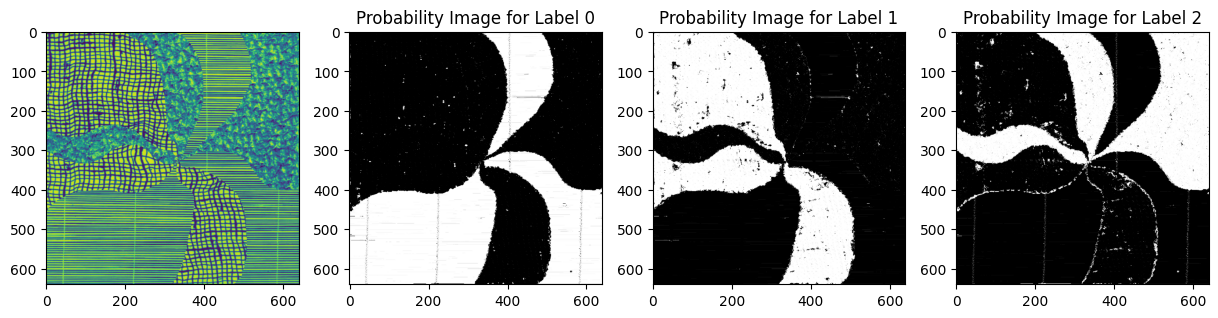

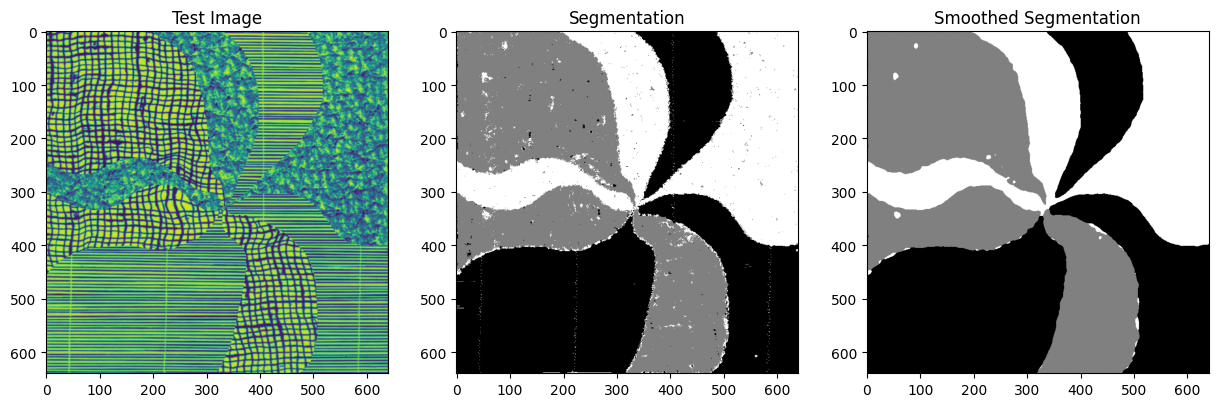

In [34]:
# === Step 1: Create Probability Image (r, c, n_l) ===
r, c = cluster_image.shape  # Shape from previous step
n_l = label_probabilities.shape[0]  # Number of labels

# Initialize probability image (r, c, n_l)
probability_image = np.zeros((r, c, n_l))

# === Step 2: Insert Cluster Probabilities ===
for i in range(r):
    for j in range(c):
        cluster_idx = cluster_image[i, j]  # Get cluster assignment
        probability_image[i, j, :] = label_probabilities[:, cluster_idx]  # Assign probabilities

# print("Probability image:", probability_image)  # (r, c, n_l)
# === Step 3: Obtain Segmentation ===
segmentation = np.argmax(probability_image, axis=2)  # Choose most probable label

# === Step 4: Smooth Probability Image ===
sigma = 3
probability_smooth = np.zeros(probability_image.shape)
for i in range(0, probability_image.shape[2]):
    probability_smooth[:, :, i] = scipy.ndimage.gaussian_filter(probability_image[:, :, i], sigma, order=0)
smoothed_segmentation = np.argmax(probability_smooth, axis=2)


# === Output Results ===
print("Probability image shape:", probability_image.shape)  # (r, c, n_l)
print("Segmentation shape:", segmentation.shape)  # (r, c)
print("Smoothed segmentation shape:", smoothed_segmentation.shape)  # (r, c)

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
ax[0].imshow(test_image)
ax[1].imshow(probability_image[:, :, 0], cmap='gray')
ax[1].set_title('Probability Image for Label 0')
ax[2].imshow(probability_image[:, :, 1], cmap='gray')
ax[2].set_title('Probability Image for Label 1')
ax[3].imshow(probability_image[:, :, 2], cmap='gray')
ax[3].set_title('Probability Image for Label 2')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_image)
ax[0].set_title('Test Image')
ax[1].imshow(segmentation, cmap='gray')
ax[1].set_title('Segmentation')
ax[2].imshow(smoothed_segmentation, cmap='gray')
ax[2].set_title('Smoothed Segmentation')
plt.show()

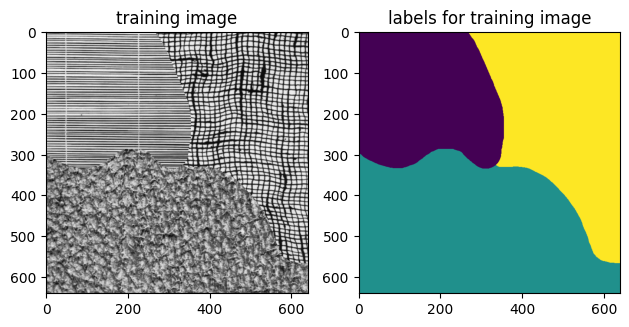

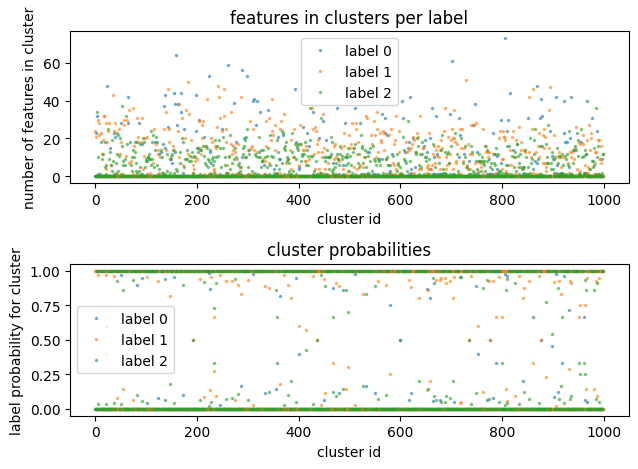

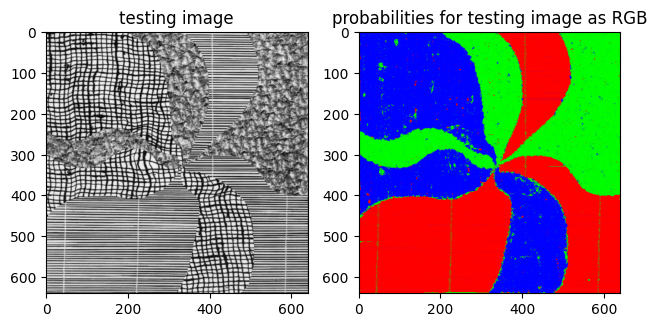

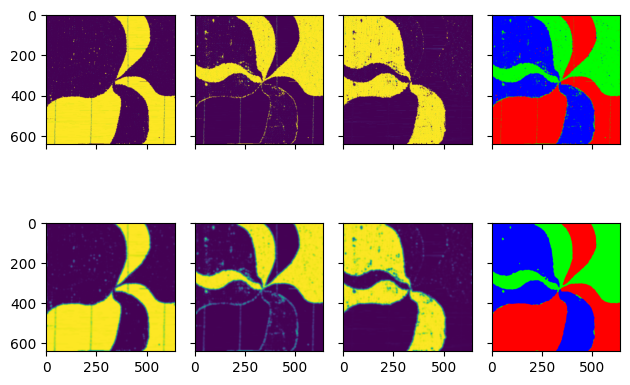

In [33]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import local_features as lf
import scipy.ndimage

def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image."""
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)

path = PATH + '/3labels/'

#%% 
# READ IN IMAGES
training_image = skimage.io.imread(path + 'training_image.png')
training_image = training_image.astype(float)
training_labels = skimage.io.imread(path + 'training_labels.png')

training_labels = ind2labels(training_labels)
nr_labels = np.max(training_labels)+1 # number of labels in the training image

fig, ax = plt.subplots(1, 2)
ax[0].imshow(training_image, cmap=plt.cm.gray)
ax[0].set_title('training image')
ax[1].imshow(training_labels)
ax[1].set_title('labels for training image')
fig.tight_layout()
plt.show()

#%% 
# TRAIN THE MODEL

sigma = [1, 2 , 3]
features = lf.get_gauss_feat_multi(training_image, sigma)
features = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
labels = training_labels.ravel()

nr_keep = 15000 # number of features randomly picked for clustering 
keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep]

features_subset = features[keep_indices]
labels_subset = labels[keep_indices]

nr_clusters = 1000 # number of feature clusters
# for speed, I use mini-batches
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, 
                                         batch_size=2*nr_clusters, 
                                         n_init='auto')
kmeans.fit(features_subset)
assignment = kmeans.labels_

edges = np.arange(nr_clusters + 1) - 0.5 # histogram edges halfway between integers
hist = np.zeros((nr_clusters, nr_labels))
for l in range(nr_labels):
    hist[:, l] = np.histogram(assignment[labels_subset == l], bins=edges)[0]
sum_hist = np.sum(hist, axis=1)
cluster_probabilities = hist/(sum_hist.reshape(-1, 1))

fig, ax = plt.subplots(2, 1)
legend_label = [f'label {x}' for x in range(nr_labels)]

ax[0].plot(hist, '.', alpha=0.5, markersize=3)
ax[0].set_xlabel('cluster id')
ax[0].set_ylabel('number of features in cluster')
ax[0].legend(legend_label)
ax[0].set_title('features in clusters per label')
ax[1].plot(cluster_probabilities, '.', alpha=0.5, markersize=3)
ax[1].set_xlabel('cluster id')
ax[1].set_ylabel('label probability for cluster')
ax[1].legend(legend_label)
ax[1].set_title('cluster probabilities')
fig.tight_layout()
plt.show()

# Finished training

#%% 
# USE THE MODEL
testing_image = skimage.io.imread(path + 'testing_image.png')
testing_image = testing_image.astype(float)

features_testing = lf.get_gauss_feat_multi(testing_image, sigma)
features_testing = features_testing.reshape((features_testing.shape[0], features_testing.shape[1]*features_testing.shape[2]))
labels = training_labels.ravel()

assignment_testing = kmeans.predict(features_testing)

probability_image = np.zeros((assignment_testing.size, nr_labels))
for l in range(nr_labels):
    probability_image[:, l] = cluster_probabilities[assignment_testing, l]
probability_image = probability_image.reshape(testing_image.shape + (nr_labels, ))

P_rgb = np.zeros(probability_image.shape[0:2]+(3, ))
k = min(nr_labels, 3)
P_rgb[:, :, :k] = probability_image[:, :, :k]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(testing_image, cmap=plt.cm.gray)
ax[0].set_title('testing image')
ax[1].imshow(P_rgb)
ax[1].set_title('probabilities for testing image as RGB')
fig.tight_layout()
plt.show()

#%%
# SMOOTH PROBABILITY MAP

sigma = 3 # Gaussian smoothing parameter

seg_im_max = np.argmax(P_rgb, axis = 2)
c = np.eye(P_rgb.shape[2])
P_rgb_max = c[seg_im_max]

probability_smooth = np.zeros(probability_image.shape)
for i in range(0, probability_image.shape[2]):
    probability_smooth[:, :, i] = scipy.ndimage.gaussian_filter(probability_image[:, :, i], sigma, order=0)
seg_im_smooth = np.argmax(probability_smooth, axis=2)

probability_smooth_max = c[seg_im_smooth]

P_rgb_smooth = np.zeros(probability_smooth_max.shape[0:2]+(3, ))
k = min(nr_labels, 3)
P_rgb_smooth[:, :, :k] = probability_smooth[:, :, :k]
P_rgb_smooth_max = np.zeros(probability_smooth_max.shape[0:2]+(3, ))
P_rgb_smooth_max[:, :, :k] = probability_smooth_max[:, :, :k]

# Display result
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True)
ax[0][0].imshow(P_rgb[:, :, 0])
ax[0][1].imshow(P_rgb[:, :, 1])
ax[0][2].imshow(P_rgb[:, :, 2])
ax[0][3].imshow(P_rgb_max)
ax[1][0].imshow(P_rgb_smooth[:, :, 0])
ax[1][1].imshow(P_rgb_smooth[:, :, 1])
ax[1][2].imshow(P_rgb_smooth[:, :, 2])
ax[1][3].imshow(P_rgb_smooth_max)
fig.tight_layout()
plt.show()
